## Data Exploration

This notebook was developed on Ubuntu 20.04, python 3.8.10. It should also work on colab.

In [27]:
%pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


### Data Preparation (converting to timestamps)

In [28]:
import pandas as pd
import networkx as nx
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

# Function to convert semester string to datetime object
def convert_semester_to_date(semester_str):
    months = {"Spring": 1, "Summer": 6, "SummerOne" : 5, "SummerTwo" : 7, "Fall": 9}
    season = ""

    if pd.isnull(semester_str):
        return None

    split_str = semester_str.split()
    year = split_str[-1]
    season_words = split_str[0:len(split_str)-1] #Because of summer sessions, EG: "Summer One 2022"
    for i in season_words:
        season += i
    
    return datetime(int(year), months[season], 1)

#Merge trans columns into pass columns
def merge_trans_classes(df):
    pass_classes = [col for col in df.columns if "Pass" in col]
    trans_classes = [col for col in df.columns if "Tran" in col]

    #Combine the trans into the pass
    for t in trans_classes:
        class_name = t.split("_")[0]
        for p in pass_classes:
            if class_name in p:
                df[p] = df[p].combine_first(df[t])

    #Drop the trans cols
    for t in trans_classes:
        df = df.drop(t,axis=1)
    
    return df    

# Load the Excel file
df = pd.read_excel('/home/lithium/Network-Science-Project/CS Course Enrollment Data 030824.xlsx')
df = merge_trans_classes(df)

# Get all the semester columns.
semester_cols = df.columns[3:-2]

for col in semester_cols:
    df[col] = df[col].apply(convert_semester_to_date)

df

,ADMIT_ACADEMIC_PERIOD_DESC,PRIMARY_1ST_MAJOR_DESC,PRIMARY_1ST_DEPARTMENT_DESC,CSCI101_Pass_Sem,CSCI128_Pass_Sem,CSCI200_Pass_C_Sem,CSCI210_Pass_Sem,CSCI220_Pass_Sem,CSCI261_Pass_C_Sem,CSCI262_Pass_Sem,...,CSCI448_Pass_Sem,CSCI455_Pass_Sem,CSCI470_Pass_Sem,CSCI471_Pass_Sem,CSCI473_Pass_Sem,CSCI474_Pass_Sem,CSCI475_Pass_Sem,CSCI477_Pass_Sem,CSCI478_Pass_Sem,Unnamed: 65
0,Fall 2018,Computer Science,Computer Science,NaT,NaT,NaT,None,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01,NaT,NaN,40
1,Spring 2018,Operations Research w/Enginrng,Economics and Business,NaT,NaT,NaT,None,NaT,NaT,2019-09-01,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,42
2,Fall 2018,Computer Science,Computer Science,2018-09-01,NaT,NaT,None,NaT,NaT,2018-09-01,...,NaT,NaT,2019-09-01,2019-09-01,NaT,NaT,NaT,NaT,NaN,29
3,Spring 2024,STEM Education,Honors,NaT,NaT,NaT,None,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,42
4,Summer 2021,Computer Science,Computer Science,NaT,NaT,NaT,None,NaT,NaT,2021-06-01,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7344,Fall 2023,Computer Science,Computer Science,NaT,2023-09-01,NaT,None,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,42
7345,Fall 2023,Computer Science,Computer Science,NaT,2023-09-01,NaT,None,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,43
7346,Spring 2024,Computer Science,Computer Science,NaT,2024-01-01,2024-01-01,None,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,42
7347,Spring 2024,Mechanical Engineering,Mechanical Engineering,NaT,2024-01-01,NaT,None,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,43


### Data Analysis

This section of the code is basically just looking at passes for a class over a specific time.

In [30]:
#If multiple classes are in the same category
combined_passes = pd.concat([
    df['CSCI406_Pass_Sem'].dropna(),
    # df['CSCI220_Tran_Sem'].dropna(),
    # df['CSCI261_Pass_C_Sem'].dropna(),
    # df['CSCI261_Tran_Sem'].dropna()
])

#Drop summer sessions.
combined_passes=combined_passes[~combined_passes.dt.month.isin([5, 6, 7])]

combined_passes = combined_passes.value_counts().sort_index()

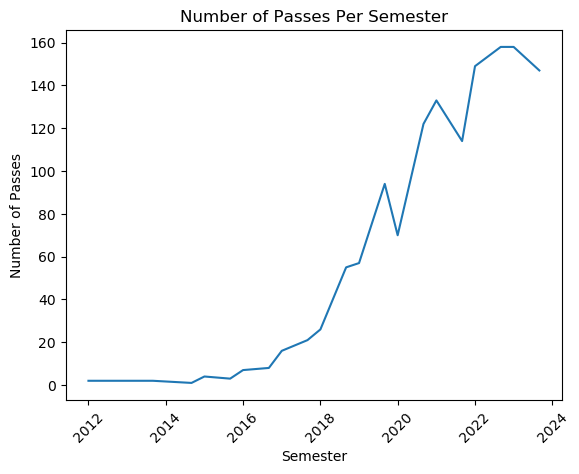

In [31]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(combined_passes)
plt.title('Number of Passes Per Semester')
plt.xlabel('Semester')
plt.ylabel('Number of Passes')
plt.xticks(rotation=45)
plt.show()
